In [3]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq

# Set the parameters
num_households = 50000  # 50,000 households
chunk_size = 10000  # Generate 10,000 households at a time
wards = 50
areas_per_ward = 10
months = 12

# Function to generate a chunk of data
def generate_chunk(start_id, chunk_size, months):
    household_ids = np.arange(start_id, start_id + chunk_size)
    ward_ids = np.random.randint(1, wards + 1, chunk_size)
    area_ids = np.random.randint(1, areas_per_ward + 1, chunk_size)
    
    # Generate water usage with seasonal effect
    base_water_usage = np.random.randint(1000, 3000, (chunk_size, months))
    seasonal_effect = np.sin(np.linspace(0, 2 * np.pi, months)).reshape(1, -1)
    monthly_water_usage = base_water_usage + (seasonal_effect * 500).astype(int)
    
    leakage_detected = np.random.choice(['Yes', 'No'], chunk_size, p=[0.1, 0.9])
    disparity_in_supply = np.random.choice(['Yes', 'No'], chunk_size, p=[0.05, 0.95])
    income_level = np.random.choice(['Low', 'Medium', 'High'], chunk_size, p=[0.3, 0.5, 0.2])
    household_size = np.random.randint(1, 10, chunk_size)
    sensor_error = np.random.normal(0, 50, (chunk_size, months)).astype(int)
    
    # Adjust water usage for income level and household size
    income_adjustment = np.where(income_level == 'Low', -200, np.where(income_level == 'High', 200, 0)).reshape(-1, 1)
    monthly_water_usage += income_adjustment
    household_size_adjustment = ((household_size - 4) * 50).reshape(-1, 1)
    monthly_water_usage += household_size_adjustment
    monthly_water_usage += sensor_error  # Add sensor error

    # Ensure no negative values
    monthly_water_usage = np.maximum(monthly_water_usage, 0).flatten()
    
    # Create repeated arrays to match the number of months
    household_ids_repeated = np.repeat(household_ids, months)
    ward_ids_repeated = np.repeat(ward_ids, months)
    area_ids_repeated = np.repeat(area_ids, months)
    leakage_detected_repeated = np.repeat(leakage_detected, months)
    disparity_in_supply_repeated = np.repeat(disparity_in_supply, months)
    income_level_repeated = np.repeat(income_level, months)
    household_size_repeated = np.repeat(household_size, months)
    dates_repeated = np.tile(pd.date_range(start='2024-01-01', periods=months, freq='M'), chunk_size)

    # Create DataFrame for the chunk
    df_chunk = pd.DataFrame({
        'Household ID': household_ids_repeated,
        'Ward': ward_ids_repeated,
        'Area': area_ids_repeated,
        'Monthly Water Usage (Liters)': monthly_water_usage,
        'Leakage Detected (Yes/No)': leakage_detected_repeated,
        'Disparity in Supply (Yes/No)': disparity_in_supply_repeated,
        'Income Level': income_level_repeated,
        'Household Size': household_size_repeated,
        'Date': dates_repeated
    })

    return df_chunk

# File to save the data
output_file = 'indore_water_usage_data_difficult.parquet'

# Initialize the Parquet file with the first chunk
initial_chunk = generate_chunk(1, chunk_size, months)
table = pa.Table.from_pandas(initial_chunk)
pq.write_table(table, output_file)

# Generate and append the rest of the data in chunks
for start_id in range(chunk_size + 1, num_households + 1, chunk_size):
    df_chunk = generate_chunk(start_id, chunk_size, months)
    table = pa.Table.from_pandas(df_chunk)
    
    # Append to existing Parquet file
    with pq.ParquetWriter(output_file, table.schema, use_dictionary=False, compression='SNAPPY') as writer:
        writer.write_table(table)
    
    print(f"Appended data for households {start_id} to {start_id + chunk_size - 1}")

print("Dataset generation completed and saved as 'indore_water_usage_data_difficult.parquet'")


Appended data for households 10001 to 20000
Appended data for households 20001 to 30000
Appended data for households 30001 to 40000
Appended data for households 40001 to 50000
Dataset generation completed and saved as 'indore_water_usage_data_difficult.parquet'


In [4]:
import pandas as pd

# Load data
df = pd.read_parquet('indore_water_usage_data_difficult.parquet')

# Ensure correct data types
df['Monthly Water Usage (Liters)'] = df['Monthly Water Usage (Liters)'].astype(float)


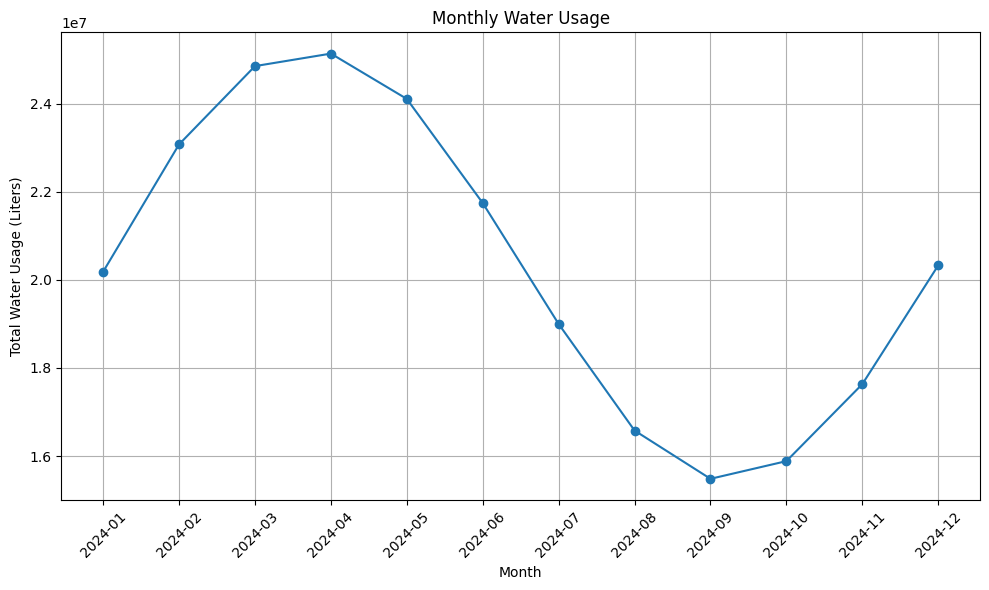

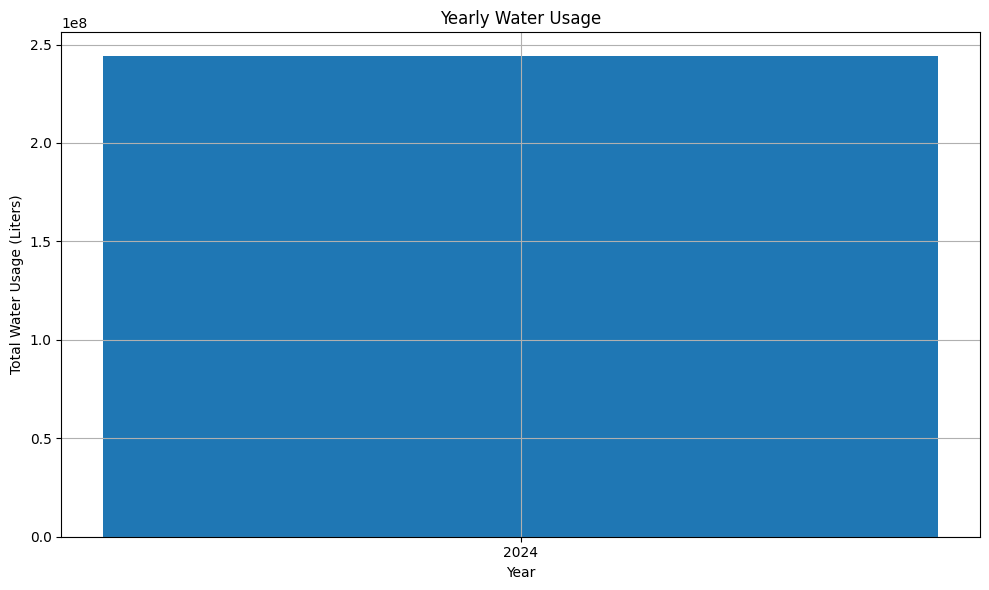

In [5]:
import matplotlib.pyplot as plt

# Monthly water usage report
monthly_report = df.groupby(df['Date'].dt.to_period('M'))['Monthly Water Usage (Liters)'].sum().reset_index()
monthly_report.columns = ['Month', 'Total Water Usage']

# Plot monthly water usage
plt.figure(figsize=(10, 6))
plt.plot(monthly_report['Month'].astype(str), monthly_report['Total Water Usage'], marker='o')
plt.title('Monthly Water Usage')
plt.xlabel('Month')
plt.ylabel('Total Water Usage (Liters)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_water_usage_report.png')
plt.show()

# Yearly water usage report
yearly_report = df.groupby(df['Date'].dt.year)['Monthly Water Usage (Liters)'].sum().reset_index()
yearly_report.columns = ['Year', 'Total Water Usage']

# Plot yearly water usage
plt.figure(figsize=(10, 6))
plt.bar(yearly_report['Year'].astype(str), yearly_report['Total Water Usage'])
plt.title('Yearly Water Usage')
plt.xlabel('Year')
plt.ylabel('Total Water Usage (Liters)')
plt.grid(True)
plt.tight_layout()
plt.savefig('yearly_water_usage_report.png')
plt.show()


In [6]:
from sklearn.ensemble import IsolationForest

# Anomaly detection for leakage
model = IsolationForest(contamination=0.01)
df['Anomaly'] = model.fit_predict(df[['Monthly Water Usage (Liters)']])
df['Anomaly'] = df['Anomaly'].map({1: 'No', -1: 'Yes'})

# Identify leakages
leakages = df[df['Anomaly'] == 'Yes']
leakages.to_csv('detected_leakages.csv', index=False)
print(leakages)


        Household ID  Ward  Area  Monthly Water Usage (Liters)  \
74             40007    24     2                        3614.0   
285            40024    18     3                         401.0   
422            40036    14     4                        3614.0   
537            40045     7     7                         443.0   
620            40052    38     2                         367.0   
...              ...   ...   ...                           ...   
119799         49984    50     4                        3737.0   
119810         49985    45     5                        3891.0   
119919         49994    38     5                        3585.0   
119948         49996     3     6                         451.0   
119954         49997    23     9                        3635.0   

       Leakage Detected (Yes/No) Disparity in Supply (Yes/No) Income Level  \
74                            No                          Yes       Medium   
285                           No                   

In [7]:
# Equitable distribution analysis
equitable_distribution = df.groupby(['Household ID'])['Monthly Water Usage (Liters)'].mean().reset_index()
equitable_distribution.columns = ['Household ID', 'Average Water Usage']

# Check for disparities
disparities = equitable_distribution[equitable_distribution['Average Water Usage'] < equitable_distribution['Average Water Usage'].quantile(0.05)]
disparities.to_csv('water_disparities.csv', index=False)
print(disparities)


      Household ID  Average Water Usage
14           40015          1584.833333
28           40029          1508.416667
44           40045          1415.000000
48           40049          1606.333333
54           40055          1599.583333
...            ...                  ...
9911         49912          1568.166667
9943         49944          1311.750000
9973         49974          1536.416667
9977         49978          1617.333333
9998         49999          1607.916667

[500 rows x 2 columns]
